# Using a Bayesian network to predict customer satisfaction

## Import components

The pgmpy library ([Ankan, 2022](https://pgmpy.org/index.html)) is used to build and query our Bayesian network. The following components are required:

In [1]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

Some additional helper libraries will be used for compilation and visualization.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

## Instantiate the model

Here we are effectively representing our 6 nodes and the links between them, if any (as outlined in the __Description__ section of the [related article](https://shotlefttodatascience.com/2025/01/27/improving-customer-satisfaction-using-bayesian-networks/)):

In [3]:
service_desk_model = BayesianNetwork([('Timing', 'SameDayResponse'),
                                     ('Difficulty', 'SameDayResponse'),
                                     ('Difficulty', 'ResolutionTime'),
                                     ('Difficulty', 'InterimUpdates'),
                                     ('InterimUpdates', 'CustomerSatisfaction'),
                                     ('SameDayResponse', 'CustomerSatisfaction'),
                                     ('ResolutionTime', 'CustomerSatisfaction')])

## Define Conditional Probability Distributions

Here we represent the (conditional) probability distributions associated with each node (as outlined in the __Construction__ section of the [related article](https://shotlefttodatascience.com/2025/01/27/improving-customer-satisfaction-using-bayesian-networks/)):

In [4]:
cpd_timing = TabularCPD(variable = 'Timing', 
                        variable_card = 2, 
                        values= [[0.6], 
                                 [0.4]], 
                        state_names = {'Timing': ['AM', 'PM']})
cpd_difficulty = TabularCPD(variable = 'Difficulty', 
                            variable_card = 3, 
                            values= [[0.1], 
                                     [0.6], 
                                     [0.3]], 
                            state_names = {'Difficulty': ['easy', 'medium', 'hard']})
cpd_response = TabularCPD(variable = 'SameDayResponse', 
                          variable_card = 2, 
                          values = [[0.95, 0.8, 0.6, 0.5, 0.3, 0.1],
                                    [0.05, 0.2, 0.4, 0.5, 0.7, 0.9]], 
                          evidence = ['Timing', 'Difficulty'], 
                          evidence_card = [2, 3], 
                          state_names = {'SameDayResponse': [True, False],
                                         'Timing': ['AM', 'PM'],
                                         'Difficulty': ['easy', 'medium', 'hard']})
cpd_updates = TabularCPD(variable = 'InterimUpdates',
                         variable_card = 3,
                         values = [[0.95, 0.3, 0.1],
                                   [0.05, 0.4, 0.5],
                                   [0,    0.3, 0.4]],
                         evidence = ['Difficulty'],
                         evidence_card = [3],
                         state_names = {'InterimUpdates': ['0', '1', '2+'],
                                        'Difficulty': ['easy', 'medium', 'hard']})
cpd_resolution = TabularCPD(variable = 'ResolutionTime', 
                            variable_card = 3, 
                            values = [[0.85, 0.4, 0.05],
                                      [0.1,  0.5, 0.2],
                                      [0.05, 0.1, 0.75]], 
                            evidence = ['Difficulty'], 
                            evidence_card = [3],
                            state_names = {'ResolutionTime': ['0-1 day', '2-3 days', '4+ days'],
                                           'Difficulty': ['easy', 'medium', 'hard']})
cpd_satisfaction = TabularCPD(variable = 'CustomerSatisfaction',
                              variable_card = 2,
                              values = [[0.9, 0.5, 0.3, 0.9, 0.6, 0.55, 0.8, 0.75, 0.7, 
                                         0.8, 0.4, 0.2, 0.8, 0.55, 0.45, 0.75, 0.65, 0.6],
                                        [0.1, 0.5, 0.7, 0.1, 0.4, 0.45, 0.2, 0.25, 0.3, 
                                         0.2, 0.6, 0.8, 0.2, 0.45, 0.55, 0.25, 0.35, 0.4]],
                              evidence = ['SameDayResponse', 'InterimUpdates', 'ResolutionTime'],
                              evidence_card = [2, 3, 3],
                              state_names = {'CustomerSatisfaction': ['OK', 'NotOK'],
                                             'SameDayResponse': [True, False], 
                                             'InterimUpdates': ['0', '1', '2+'], 
                                             'ResolutionTime': ['0-1 day', '2-3 days', '4+ days']})

## Assemble the model and validate

If ```check_model()``` returns True there are no errors in our model. We can also check that each of the 6 CPD's we added to our model are present as expected.

In [5]:
service_desk_model.add_cpds(cpd_timing, cpd_difficulty, cpd_response, cpd_resolution, cpd_updates, cpd_satisfaction)
print(f'''Model OK? {service_desk_model.check_model()}''')
service_desk_model.get_cpds()

Model OK? True


[<TabularCPD representing P(Timing:2) at 0x7fd405716b90>,
 <TabularCPD representing P(Difficulty:3) at 0x7fd405716b30>,
 <TabularCPD representing P(SameDayResponse:2 | Timing:2, Difficulty:3) at 0x7fd405716c20>,
 <TabularCPD representing P(ResolutionTime:3 | Difficulty:3) at 0x7fd405716bf0>,
 <TabularCPD representing P(InterimUpdates:3 | Difficulty:3) at 0x7fd405716bc0>,
 <TabularCPD representing P(CustomerSatisfaction:2 | SameDayResponse:2, InterimUpdates:3, ResolutionTime:3) at 0x7fd405716b60>]

## Instantiate the inference object and query

In [6]:
servicedesk_inference = VariableElimination(service_desk_model)

### Query 1 - What is the probability of OK CustomerSatisfaction, given the initial ticket state?

One of the advantages of Bayesian networks is that we can obtain probability distributions for combinations that we did not define upfront. So at each stage where we have new information we can obtain the latest probability of customer satisfaction given what we know up to that point. For instance, having input all the conditional probabilities into our network above, we can now create a query to establish what the overall probability of customer satisfaction currently is at the outset of a ticket being logged. At this point, we will have just 2 pieces of information available: ```Timing``` and ```Difficulty```. Given just these 2 pieces of information we can obtain the initial probabilities for an OK customer satisfaction outcome:

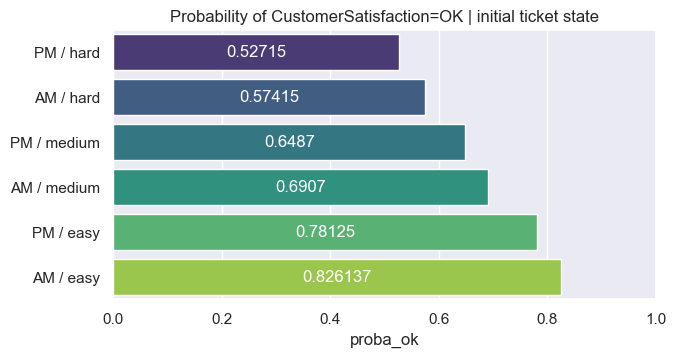

In [7]:
# Get output probabilities, based on combinations of input probabilities
q1_probas = {}
for i in cpd_timing.state_names['Timing']:
    for j in cpd_difficulty.state_names['Difficulty']:
        proba = servicedesk_inference.query(
                                          variables = ['CustomerSatisfaction'], 
                                          evidence = {'Timing':i, 'Difficulty':j}, joint=False)
        q1_probas[f'''{i} / {j}'''] = proba['CustomerSatisfaction'].values[0]

# Convert to dataframe for easier plotting
q1_probas = pd.DataFrame.from_dict(q1_probas, orient='index')
q1_probas.reset_index(inplace = True, names = 'key')
q1_probas.columns = ['initial_state', 'proba_ok']

# Plot the results
# Color options from Stern (2016):
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
fig, ax = plt.subplots(figsize=(7, 3.5))
pal = sns.color_palette("viridis_r", len(q1_probas))
rank = q1_probas['proba_ok'].sort_values().argsort().argsort()
sns.barplot(data = q1_probas.sort_values('proba_ok'), x='proba_ok', y='initial_state', 
            palette=np.array(pal[::-1])[rank], orient= 'h', ax=ax)
ax.bar_label(ax.containers[0], label_type = 'center', color = 'white')
ax.set(ylabel=None)
plt.title('Probability of CustomerSatisfaction=OK | initial ticket state')
plt.xlim(0, 1)
plt.savefig('query1.png', dpi=600, bbox_inches='tight')
plt.show()

Here we can already see that irrespective of what time of day a ticket is logged, hard tickets are very much more at risk of a poor customer satisfaction outcome, followed by medium, followed by easy. We can also see that in each instance tickets logged in the afternoon are _even_ more at risk than their counterparts logged in the morning. This all makes intuitive sense, but it is insightful to see the _extent_ of the differences: it drives home the need to put in extra effort with those harder tickets.

### Query 2 - given a hard ticket, quantify the impact of resolution time and interim updates?

Since the hard tickets are most at risk, how should we best handle these tickets over time?

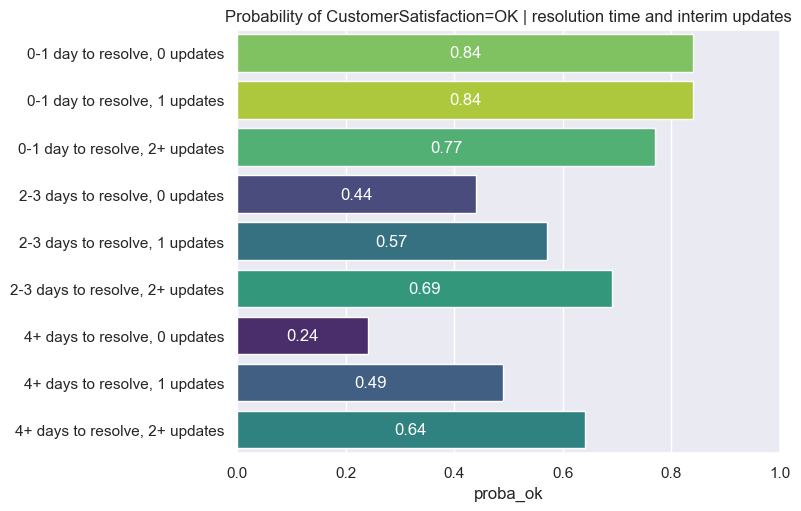

In [8]:
# Get output probabilities, based on combinations of input probabilities
q2_probas = {}
for i in cpd_updates.state_names['InterimUpdates']:
    for j in cpd_resolution.state_names['ResolutionTime']:
        proba = servicedesk_inference.query(
                                          variables = ['CustomerSatisfaction'], 
                                          evidence = {'Difficulty':'hard', 
                                                      'InterimUpdates':i, 
                                                      'ResolutionTime': j}, joint=False)
        q2_probas[f'''{j} to resolve, {i} updates'''] = proba['CustomerSatisfaction'].values[0]

# Convert to dataframe for easier plotting
q2_probas = pd.DataFrame.from_dict(q2_probas, orient='index')
q2_probas.reset_index(inplace = True, names = 'key')
q2_probas.columns = ['actions', 'proba_ok']

# Plot the results
fig, ax = plt.subplots(figsize=(7, 5.5))
pal = sns.color_palette("viridis_r", len(q2_probas))
rank = q2_probas.sort_values(['actions', 'proba_ok'])['proba_ok'].argsort().argsort()
sns.barplot(data = q2_probas.sort_values(['actions', 'proba_ok']), x='proba_ok', y='actions', 
            palette=np.array(pal[::-1])[rank], orient= 'h', ax=ax)
ax.bar_label(ax.containers[0], label_type = 'center', color = 'white')
ax.set(ylabel=None)
plt.title('Probability of CustomerSatisfaction=OK | resolution time and interim updates')
plt.xlim(0, 1)
plt.savefig('query2.png', dpi=600, bbox_inches='tight')
plt.show()

From the above, we can see that during days 0-1 we need not worry with interim updates. If we're working on the ticket and we're highly likely to finish it within 1 day then just keep working and get it done because we're on track for a decent customer satisfaction outcome. In fact too _many_ updates within a short space of time appear to result in a lower customer satisfaction probability (0.77 for 2+ updates compared with 0.84 for the rest)! 

However, once the ticket drags on into the 2-3 day timespan updates become important: there should be at least 1 update to ensure there is still a chance of customer satisfaction. 

And by the time we reach the 4+ days timespan at least 2 updates should have been issued to stay on track for a good outcome.

### Query 3 - Given a ticket's satisfaction outcome - what is the probability it received a same-day response?

In this instance we are backtracking within the model: given that a ticket received a particular customer satisfaction outcome, what is the probability it received a same-day response?

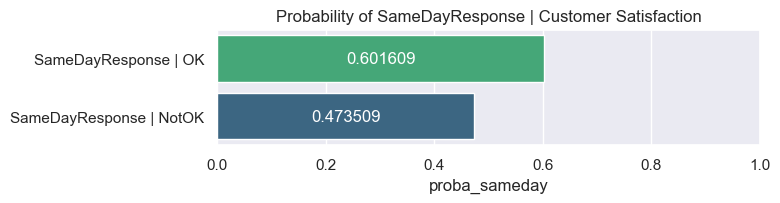

In [9]:
# Get output probabilities, based on combinations of input probabilities
q3_probas = {}
for i in cpd_satisfaction.state_names['CustomerSatisfaction']:
    proba = servicedesk_inference.query(variables = ['SameDayResponse'], 
                                        evidence = {'CustomerSatisfaction':i}, joint=False)
    q3_probas[f'''SameDayResponse | {i}'''] = proba['SameDayResponse'].values[0]
    
# Convert to dataframe for easier plotting
q3_probas = pd.DataFrame.from_dict(q3_probas, orient='index')
q3_probas.reset_index(inplace = True, names = 'key')
q3_probas.columns = ['satisfaction', 'proba_sameday']

# Plot the results
fig, ax = plt.subplots(figsize=(7, 1.5))
pal = sns.color_palette("viridis_r", len(q3_probas))
rank = q3_probas['proba_sameday'].argsort().argsort()
sns.barplot(data = q3_probas, x='proba_sameday', y='satisfaction', 
            palette=np.array(pal[::-1])[rank], orient= 'h', ax=ax)
ax.bar_label(ax.containers[0], label_type = 'center', color = 'white')
ax.set(ylabel=None)
plt.title('Probability of SameDayResponse | Customer Satisfaction')
plt.xlim(0, 1)
plt.savefig('query3.png', dpi=600, bbox_inches='tight')
plt.show()

Again, the sentiment behind these numbers could probably be intuited by most rational service desk agents, but to quantify the extent of the difference that a same day response makes in this way is much more impactful - and demonstrates clearly how a quick, simple action like responding to the customer sooner rather than later can make all the difference!